# MCS case July 2008 as simulated by 20 ensemble members

Created by Julia Kukulies 

- variables
    - pr: precipitation
    - olr: outgoing longwave radiation 
    - swe: snow water equivalent 
    - tas: surface temperature 
    

# Precipitation



## Maps of accumulated precipitation 

In [4]:
import numpy as np
from pathlib import Path
import xarray as xr
import re 
import glob


## for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
from matplotlib import ticker, cm
import seaborn as sns 
from analysis import get_experiments, get_precip, get_precip_gpm, haversine, make_plot

import warnings
warnings.filterwarnings('ignore')

In [172]:
### list all files that contain accumulated precipitation ###

path = Path('/media/juli/Data/projects/data/model/')
files= path.glob('accumulated_precip_cptp/*20-21*nc')
file_list = [x for x in files if x.is_file()]
file_list.sort()
experiments = get_experiments(file_list, 'evaluation_', '_v1_hour')


# get elevation data  
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevation = xr.open_dataset(dem)
elevations = elevation.__xarray_dataarray_variable__.values
la = elevation.lat
lo = elevation.lon
elevation.close()


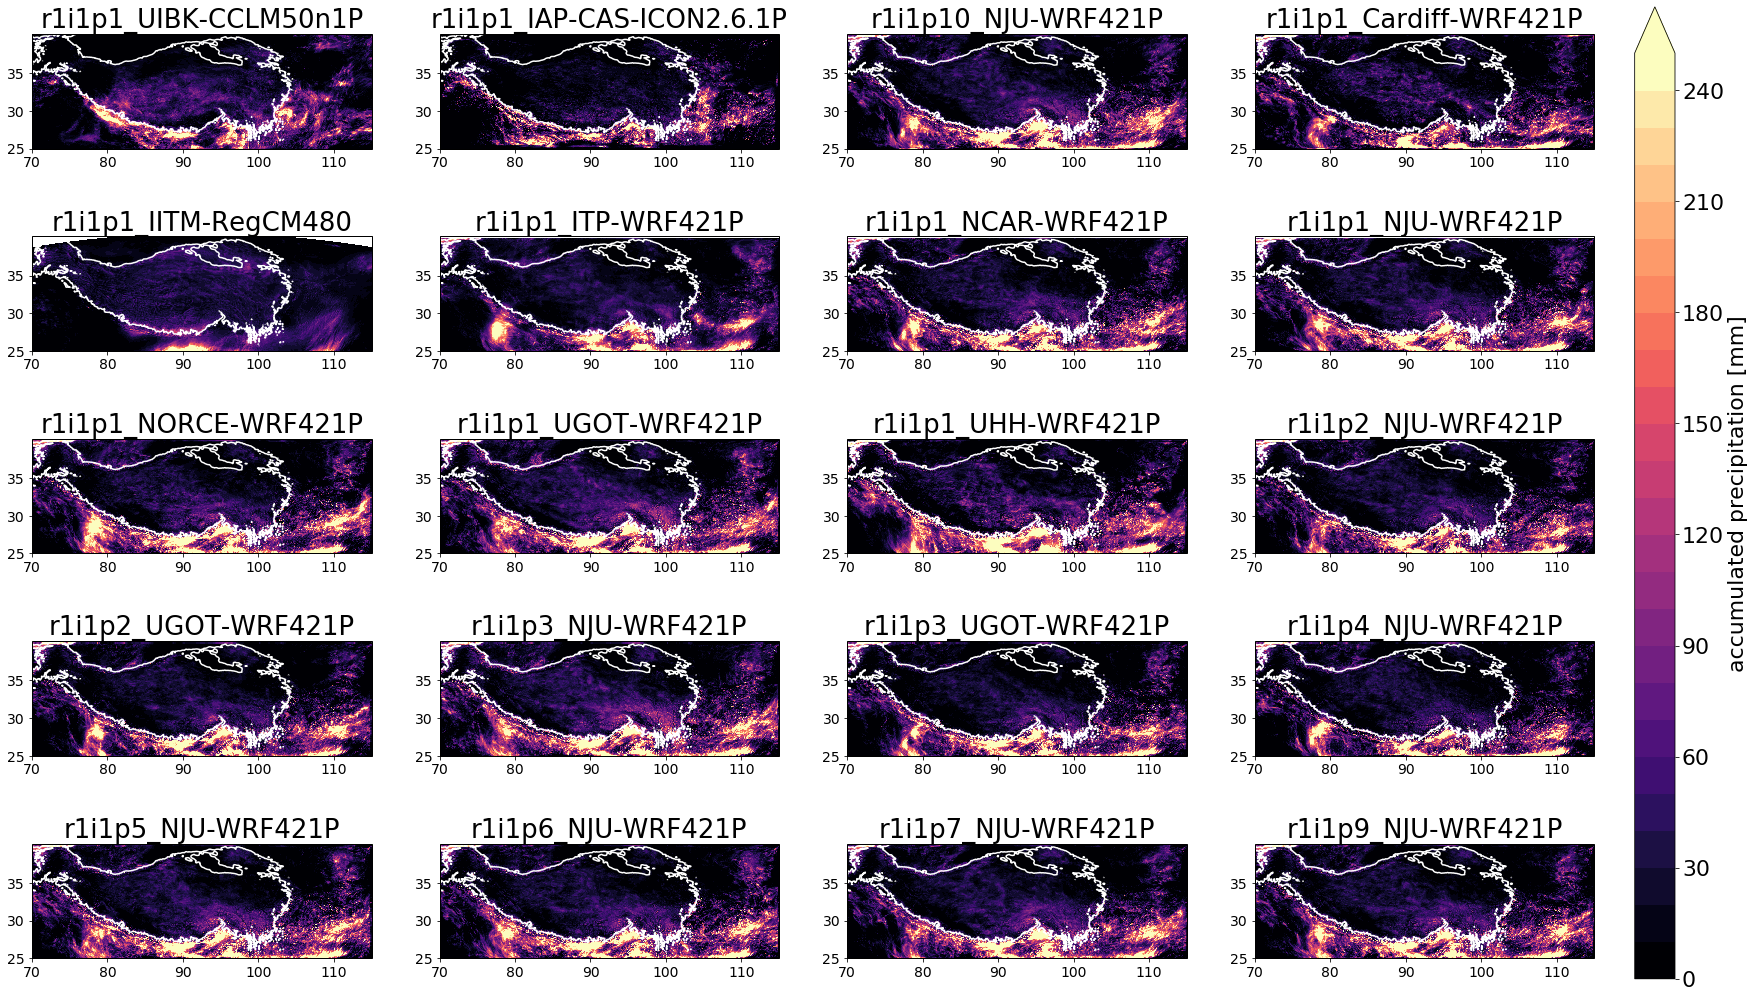

In [31]:
fig =plt.figure(figsize=(28,18))

# customizing of colorbar 
cmap=plt.cm.magma
r = np.arange(0,260,20)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
levels = [0,10,20,30,50,100,150,200,250,300,500] 
fs= 26
p = 1

for f in file_list:
    # read in data 
    data = xr.open_dataset(f).pr[0] * 3600
    lon = data.lon
    lat = data.lat
    xlon = [70,80,90,100,110]
    ylat = [25,30,35]
    name= experiments[p-1] 
    
    # make subplot 
    ax = plt.subplot(5, 4, p, projection=ccrs.PlateCarree())
    ax.set_extent([70,115,25,38])
    m=ax.pcolormesh(lon, lat, data, norm = norm, cmap = cmap)
    ax.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys')
    ax.coastlines(color = 'black')
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title(name, fontsize= fs)
    p += 1 
    data.close()

cb_ax2 = fig.add_axes([0.92, 0.13,0.02, 0.75])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', label = 'accumulated precipitation [mm]')
plt.rcParams.update({'font.size': 26})
    
plt.tight_layout()
plt.savefig('plots/comparison_map_accumulated_precip_18-23_july2008.png')
plt.show()

In [49]:
def make_plot(x, y, data, title):

    cmap=plt.cm.magma
    r = np.arange(0,260,20)
    norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
    fs = 25 

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([70,115,25,38])
    xlon = [70,80,90,100,110]
    ylat = [25,30,35]
    m=ax.pcolormesh(x,y, data, norm = norm, cmap = cmap)
    ax.contour(lo,la,  elevation.__xarray_dataarray_variable__.T, [3000], cmap = 'Greys')
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title(title, fontsize= fs)
    return m


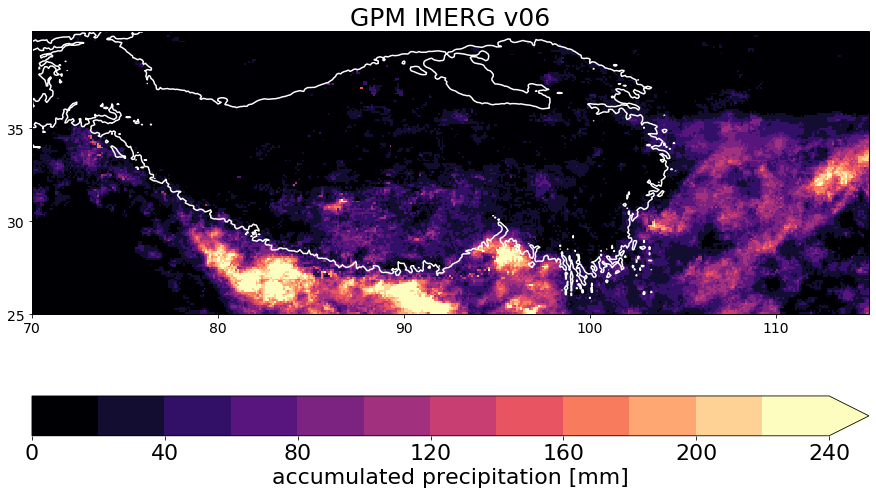

In [50]:
## comparison to GPM
gpm= Path('/media/juli/Elements/gpm_v06/2008/gpm_imerg_200807_18-25_accumulated.nc')
prcp = xr.open_dataset(gpm).precipitationCal[0] * 0.5
lon = prcp.lon
lat = prcp.lat

fig =plt.figure(figsize=(15,10))
m= make_plot(lon, lat, prcp.T.values, title = 'GPM IMERG v06')

# customize colorbar 
cbar = fig.colorbar(m, orientation = 'horizontal', extend = 'max', label = 'accumulated precipitation [mm]')
plt.rcParams.update({'font.size': 22})
plt.tight_layout()
plt.savefig('plots/GPM_map_accumulated_precip_18-23_july2008.png')
plt.show()

## Time series graph with accumulated precipitation around TPV center 


The TPV persisted from 18/07/2008 12:00 to 21/07/2008 12:00 UTC.

In [3]:
## read in ERA5 track 
import pandas as pd 
from scipy import interpolate 
track_era5 = pd.read_table('/media/juli/Data/projects/moisture_transport/tpv_2008_awt/ERA5_TPV_track.txt', sep = '\s',names = ['time', 'lon', 'lat', 'geopotential'])
# interpolat timesteps to hourly to facilitate comparison 
f = interpolate.interp1d(track_era5.lon.values, track_era5.lat.values)
tpv_lon = np.linspace(track_era5.lon.values.min(), track_era5.lon.values.max(), 73)
tpv_lat = f(tpv_lon)  

In [65]:
## create dictionary with precip calculation for each experiment 

paths = Path('/media/juli/Data/projects/data/model/CPTP/').glob('*/Hourly/')
paths = [x for x in paths if x.is_dir()]
precip= dict()

for p in paths:
    file_list= p.glob('*hour*.nc')
    files = [x for x in file_list if x.is_file()]
    files.sort()
    experiment = files[0].parents[1].stem
    precip[experiment] = get_precip(tpv_lon, tpv_lat, files)

In [5]:
gpm_files = glob.glob('/media/juli/Data/projects/moisture_transport/tpv_2008_awt/hourly/gpm_hourly*nc')
gpm_files.sort()
gpm_precip= get_precip_gpm(tpv_lon, tpv_lat, gpm_files)

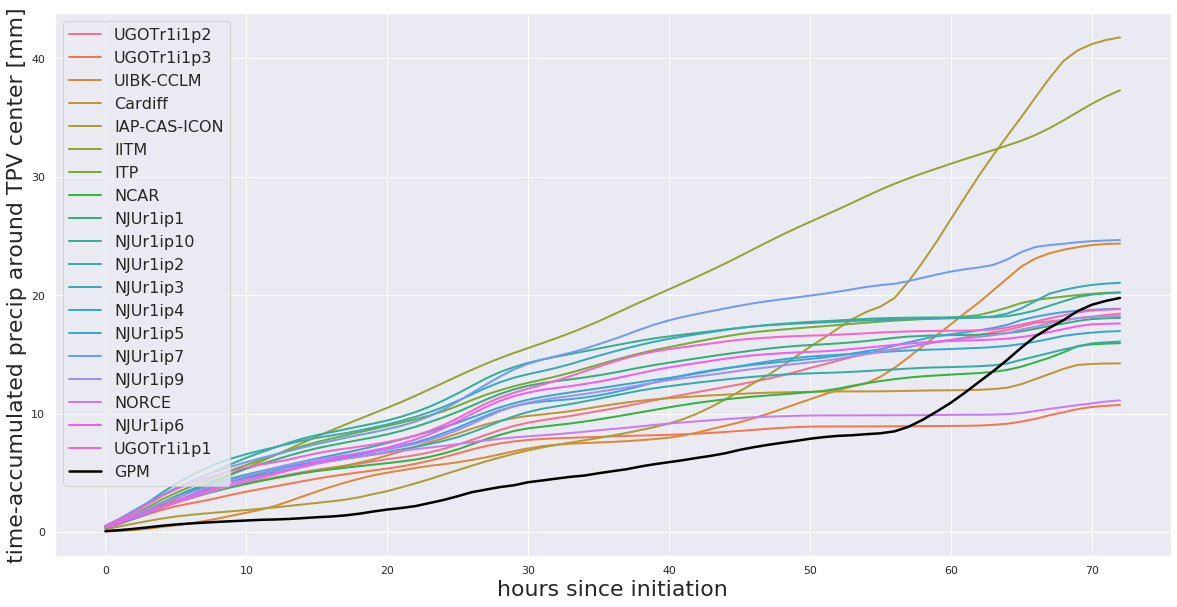

In [81]:
plt.figure(figsize= (20,10))
sns.set() 
sns.set_palette("husl", 20)
fs= 22

for key in precip.keys():
    plt.plot(precip[key], label = key, linewidth = 2.0)
    i+=1 

plt.plot(gpm_precip, label = 'GPM', color = 'black', linewidth = 2.5)
plt.legend(fontsize = 16)
plt.grid(True)
plt.ylabel('time-accumulated precip around TPV center [mm]', fontsize = fs )
plt.xlabel('hours since initiation', fontsize = fs)

plt.savefig('plots/time_accumulated_precip_around_TPV_center.png')
plt.show()

## Evolution of precipitation in Sichuan basin (where the flooding occurred)

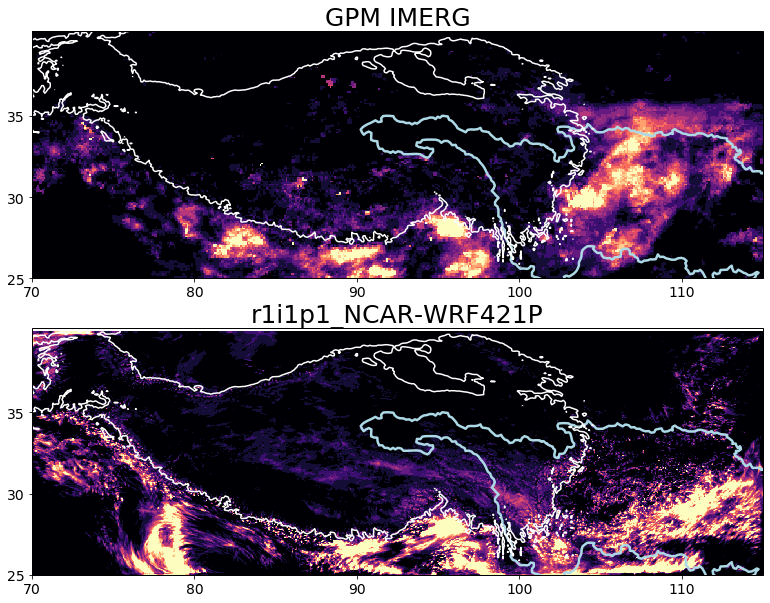

In [179]:
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader


gpm= Path('/media/juli/Elements/gpm_v06/2008/gpm_imerg_20080720-21_accumulated.nc4')
prcp = xr.open_dataset(gpm).precipitationCal[0] * 0.5
lon = prcp.lon
lat = prcp.lat


# Read shape file

plt.figure(figsize=(20,10))
cmap=plt.cm.magma
r = np.arange(0,120,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
fname = 'yangtze/yangtze.shp'
fs=25
ax = plt.axes(projection= ccrs.PlateCarree())
shape_feature = ShapelyFeature(Reader(fname).geometries(),
              
                               
                            ccrs.PlateCarree(), edgecolor='lightblue', facecolor = 'None', linewidth= 2.5)




ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([70,115,25,38])
xlon = [70,80,90,100,110]
ylat = [25,30,35]
m=ax.pcolormesh(lon, lat, prcp.T.values, cmap=cmap, norm=norm)
ax.contour(lo,la,  elevation.__xarray_dataarray_variable__.T, [3000], cmap = 'Greys')
ax.set_xticks(xlon)
ax.set_xticklabels(xlon, fontsize= 14)
ax.set_yticks(ylat)
ax.set_yticklabels(ylat, fontsize= 14)
ax.set_title('GPM IMERG', fontsize= fs)
ax.add_feature(shape_feature)



ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax.set_extent([70,115,25,38])
xlon = [70,80,90,100,110]
ylat = [25,30,35]


data = xr.open_dataset(file_list[6])
prcp= data.pr[0] * 3600
lon = data.lon
lat = data.lat

m=ax.pcolormesh(lon, lat, prcp, cmap=cmap, norm=norm)
ax.contour(lo,la,  elevation.__xarray_dataarray_variable__.T, [3000], cmap = 'Greys')
ax.set_xticks(xlon)
ax.set_xticklabels(xlon, fontsize= 14)
ax.set_yticks(ylat)
ax.set_yticklabels(ylat, fontsize= 14)
ax.set_title(experiments[6], fontsize= fs)
ax.add_feature(shape_feature)

plt.savefig('comparison_wrf-ncar_gpm.png')

plt.show()

In [159]:
def basin_mask(file, variable, coords = True):
    import geopandas
    import rioxarray
    import xarray
    from shapely.geometry import mapping
    
    basin = geopandas.read_file('yangtze/yangtze.shp', crs="epsg:4326")
    
    data = xr.open_dataset(file)

    if coords is False:
        data_vars= dict(pr=(["lat", "lon"], data.pr.values[0]))
        coords = dict( lat= data.lat.values[:,0], lon = data.lon.values[0])
        data= xr.Dataset(data_vars= data_vars, coords = coords)
        precip = data[variable]
        precip.rio.set_spatial_dims(x_dim=precip.dims[1], y_dim= precip.dims[0], inplace=True)
    else:
        precip = data[variable]
        precip.rio.set_spatial_dims(x_dim=precip.dims[1], y_dim= precip.dims[2], inplace=True)
    precip.rio.write_crs("epsg:4326", inplace=True)
    return precip.rio.clip(basin.geometry.apply(mapping), basin.crs, drop=False)


- go through model simulations, mask, get timeseries, plot area weighted sum over days 

## Observations and notes 

- over a longer time period (e.g. ~5 days), more precip is produced south of the Himalayas -> shows importance of short-term precip and that Sichuan basin is "not as used" to heavy precip as the basins south of the Himalayas, which probably increased the flooding risk? 
- time lag in some simulations? (e.r. **r1i1p4_NJU-WRF421P** )
- most similar to GPM on first view: **r1i1p1_UIBK-CCLM50n1P** and **r1i1p1_IAP-CAS-ICON2.6.1P**